In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
import xgboost as xgb
import lightgbm as lgb
import optuna
from optuna.integration import LightGBMPruningCallback
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
# uid: a unique ID for each pitch in the dataset
# is_hr: whether a pitch was a home run
# pitch_type - The type of pitch derived from Statcast.
# game_date - Date of the Game.
# release_speed - Pitch velocities from 2008-16 are via Pitch F/X, and adjusted to roughly out-of-hand release point. All velocities from 2017 and beyond are Statcast, which are reported out-of-hand.
# release_pos_x - Horizontal Release Position of the ball measured in feet from the catcher's perspective. left-right movement
# release_pos_y - Release position of pitch measured in feet from the catcher's perspective. front-back moevement
# release_pos_z - vertical Release Position of the ball measured in feet from the catcher's perspective. height from catchers persp. 
# player_name - Player's name tied to the event of the search.
# batter - MLB Player Id tied to the play event.
# pitcher - MLB Player Id tied to the play event.
# events - Event of the resulting Plate Appearance.
# description - Description of the resulting pitch.
# spin_dir - Deprecated field from the old tracking system.
# spin_rate_deprecated - Deprecated field from the old tracking system. Replaced by release_spin
# break_angle_deprecated - Deprecated field from the old tracking system.
# break_length_deprecated - Deprecated field from the old tracking system.
# zone - Zone location of the ball when it crosses the plate from the catcher's perspective.
# des - Plate appearance description from game day.
# game_type - Type of Game. E = Exhibition, S = Spring Training, R = Regular Season, F = Wild Card, D = Divisional Series, L = League Championship Series, W = World Series
# stand - Side of the plate batter is standing.
# p_throws - Hand pitcher throws with.
# home_team - Abbreviation of home team.
# away_team - Abbreviation of away team.
# type - Short hand of pitch result. B = ball, S = strike, X = in play.
# hit_location - Position of first fielder to touch the ball.
# bb_type - Batted ball type, ground_ball, line_drive, fly_ball, popup.
# balls - Pre-pitch number of balls in count.
# strikes - Pre-pitch number of strikes in count.
# sz_top - Top of the batter's strike zone set by the operator when the ball is halfway to the plate.
# sz_bot - Bottom of the batter's strike zone set by the operator when the ball is halfway to the plate.
# inning - Pre-pitch inning number.
# inning_topbot - Pre-pitch top or bottom of inning.
# outs_when_up - Pre-pitch number of outs.
# at_bat_number - Plate appearance number of the game.
# launch_speed - Exit velocity of the batted ball as tracked by Statcast. For the limited subset of batted balls not tracked directly, estimates are included based on the process described here.
# launch_angle - Launch angle of the batted ball as tracked by Statcast. For the limited subset of batted balls not tracked directly, estimates are included based on the process described here.
# release_speed - Pitch velocities from 2008-16 are via Pitch F/X, and adjusted to roughly out-of-hand release point. All velocities from 2017 and beyond are Statcast, which are reported out-of-hand.
# spin_rate_deprecated - Deprecated field from the old tracking system. Replaced by release_spin
# spin_axis - The Spin Axis in the 2D X-Z plane in degrees from 0 to 360, such that 180 represents a pure backspin fastball and 0 degrees represents a pure topspin (12-6) curveball
# pfx_x - Horizontal movement in feet from the catcher's perspective.
# pfx_z - Vertical movement in feet from the catcher's perpsective.
# plate_x - Horizontal position of the ball when it crosses home plate from the catcher's perspective.
# plate_z - Vertical position of the ball when it crosses home plate from the catcher's perspective.
# hc_x - Hit coordinate X of batted ball.
# hc_y - Hit coordinate Y of batted ball.

## Helper Functions

In [3]:
def plot_numerical_variable(numeric_features, train, test):
    len_num = len(numeric_features)
    
    len_num = len_number(len_num)
    
    fig, axes = plt.subplots(nrows=len_num, ncols=2, figsize=(20, 20))
    print(f"\n===============Numerical Features===============")
    
    # Flatten axes array to iterate over subplots
    axes = axes.flatten()
    
    for i, features in enumerate(numeric_features):
        ax=axes[i]
        sns.histplot(train[features], kde=False, ax=ax)
        sns.histplot(test[features], kde=False, ax=ax)
        ax.set_xlabel(features)
        ax.set_title(features)
    plt.tight_layout()
    plt.show()

In [4]:
def plot_categorical_variable(categorical_features, train, test):
    len_cat = len(categorical_features)
    
    len_cat = len_number(len_cat)
    
    fig, axes = plt.subplots(nrows=len_cat, ncols=2, figsize=(30, 20))
    print(f"\n===============Categorical Features===============")
    
    # Flatten axes array to iterate over subplots
    axes = axes.flatten()
    
    for i, features in enumerate(categorical_features):
        ax=axes[i]
        sns.histplot(train[features], kde=False, ax=ax)
        sns.histplot(test[features], kde=False, ax=ax)
        ax.set_xlabel(features)
        ax.set_title(features)
    plt.tight_layout()
    plt.show()

In [5]:
def len_number(num):
        if num%2==0:
            return num//2
        else:
            return (num//2) + 1

In [6]:
def convert_tocategory(df):
    for i in df.select_dtypes('object').columns:
        df[i] = df[i].astype('category')
    
    return df

In [7]:
## How many bases home team touch
def bases_features(df):
    df['on_1b'] = df['on_1b'].astype(int)
    df['on_2b'] = df['on_2b'].astype(int)
    df['on_3b'] = df['on_3b'].astype(int)
    
    df['bases_count'] = np.sum(df[df.columns[df.columns.str.contains('on')]], axis=1)
    return df

In [8]:
def distance_features(df):
    df['dist_xy'] = np.sqrt(np.square(df['release_pos_y']) + np.square(df['release_pos_x']))
    df['dist_yz'] = np.sqrt(np.square(df['release_pos_y']) + np.square(df['release_pos_z']))
    df['dist_xz'] = np.sqrt(np.square(df['release_pos_x']) + np.square(df['release_pos_z']))
    
    return df

In [9]:
def transform_features(df):
    ## Batting statistics
#     df['homerun_perhometeam'] = df.groupby('home_team')['is_hr'].transform('sum')
    df['bases_perhometeam'] = df.groupby('home_team')['bases_count'].transform('sum')
    
#     df['homerun_perpitchtype'] = df.groupby('pitch_type')['is_hr'].transform('sum')
    df['basescount_perpitchtype'] = df.groupby('pitch_type')['bases_count'].transform('sum')
    
#     df['homerun_perbatterpitcher_pos'] = df.groupby(['stand', 'p_throws'])['is_hr'].transform('sum')
    df['basescount_perbatterpitcher_pos'] = df.groupby(['stand', 'p_throws'])['bases_count'].transform('sum')
    
    ## Bowling Stattistics - balls, strikes, out
#     df['homerun_perout'] = df.groupby('outs_when_up')['is_hr'].transform('sum')
    df['basescount_perout'] = df.groupby('outs_when_up')['bases_count'].transform('sum')
    
#     df['homerun_perhtperout'] = train_df.groupby(['home_team', 'outs_when_up'])['is_hr'].transform('sum')
    df['homerun_perhtperout'] = df.groupby(['home_team', 'outs_when_up'])['bases_count'].transform('sum')
    
#     df['homerun_perstrike'] = df.groupby('strikes')['is_hr'].transform('sum')
    df['basescount_perstrike'] = df.groupby('strikes')['bases_count'].transform('sum')
    
#     df['homerun_perhtperstrike'] = df.groupby(['home_team', 'strikes'])['is_hr'].transform('sum')
    df['homerun_perhtperstrike'] = df.groupby(['home_team', 'strikes'])['bases_count'].transform('sum')
    
#     df['homerun_perballs'] = df.groupby('balls')['is_hr'].transform('sum')
    df['basescount_perballs'] = df.groupby('balls')['bases_count'].transform('sum')
    
#     df['homerun_perhtperballs'] = df.groupby(['home_team', 'balls'])['is_hr'].transform('sum')
    df['homerun_perhtperballs'] = df.groupby(['home_team', 'balls'])['bases_count'].transform('sum')
    
    df['pitchnumber_binned'] = df['pitch_number'].replace([9, 10, 11, 12, 13, 14], 9)
    
    ## Fielding
#     df['homerun_perfielding'] = df.groupby(['if_fielding_alignment', 'of_fielding_alignment'])['is_hr'].transform('sum')
    df['basescount_perfielding'] = df.groupby(['if_fielding_alignment', 'of_fielding_alignment'])['bases_count'].transform('sum')
    
    df['out_perfielding'] = df.groupby(['if_fielding_alignment', 'of_fielding_alignment'])['outs_when_up'].transform('sum')
    df['balls_perfielding'] = df.groupby(['if_fielding_alignment', 'of_fielding_alignment'])['balls'].transform('sum')
    df['strikes_perfielding'] = df.groupby(['if_fielding_alignment', 'of_fielding_alignment'])['strikes'].transform('sum')
    
    
    df['launch_angle'] = df['launch_angle'].replace(0, 1)
    df['launch_speed_angle'] = df['launch_speed'] / df['launch_angle']
    
    df['hit_distance'] = np.sqrt(np.square(df['hc_x']) + np.square(df['hc_y']))
    df['plate_distance'] = np.sqrt(np.square(df['plate_x']) + np.square(df['plate_z']))
    df['pfx_distance'] = np.sqrt(np.square(df['pfx_x']) + np.square(df['pfx_z']))
    
    df['spin_axis'] = df['spin_axis'].replace(0, 1)
    df['release_acc'] = df['spin_axis'] * df['release_speed']
    
    return df

In [10]:
train_df = pd.read_csv('/kaggle/input/nwds-xhr/train.csv')
display(train_df)
test_df = pd.read_csv('/kaggle/input/nwds-xhr/test.csv')
display(test_df)

,uid,home_team,sz_top,sz_bot,pitch_type,release_pos_x,release_pos_y,release_pos_z,stand,p_throws,...,release_spin_rate,pfx_x,pfx_z,plate_x,plate_z,hc_x,hc_y,launch_speed,launch_angle,is_hr
0,0,LAA,3.35,1.61,CU,-2.14,53.69,6.48,R,R,...,2110,0.73,-0.79,-0.11,3.19,138.97,86.01,94.6,47,0
1,2,LAA,3.39,1.63,CH,1.83,54.15,5.94,R,L,...,1710,1.22,0.71,0.74,1.44,111.73,159.90,69.5,-30,0
2,4,LAA,3.46,1.59,CU,-2.32,53.99,6.43,L,R,...,2154,0.73,-0.67,-0.32,2.69,112.87,148.15,93.8,66,0
3,5,LAA,3.29,1.54,SL,-2.01,53.71,6.37,R,R,...,2209,0.50,0.98,-0.20,2.14,180.78,96.91,87.5,38,0
4,6,LAA,3.47,1.65,FF,-2.16,53.61,6.29,L,R,...,2230,-0.29,1.60,0.00,2.89,134.75,101.76,100.0,-2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97304,117303,BAL,3.32,1.58,FF,-2.01,53.61,6.23,R,R,...,2174,-0.45,1.40,-0.08,3.00,142.97,122.30,64.7,43,0
97305,117304,LAD,3.47,1.59,CH,-2.21,54.49,5.75,R,R,...,1275,-1.00,0.19,-0.05,1.30,118.16,181.76,42.4,-63,0
97306,117305,SEA,3.39,1.59,SL,-0.86,54.31,6.13,L,R,...,2229,0.09,0.30,-0.10,1.91,148.57,92.07,90.2,44,0
97307,117306,SEA,3.39,1.59,SL,-2.30,54.56,5.97,L,R,...,2680,0.93,-0.23,0.32,3.18,167.00,114.98,71.3,26,0


,uid,home_team,sz_top,sz_bot,pitch_type,release_pos_x,release_pos_y,release_pos_z,stand,p_throws,...,spin_axis,release_spin_rate,pfx_x,pfx_z,plate_x,plate_z,hc_x,hc_y,launch_speed,launch_angle
0,100541,BOS,3.33,1.59,SL,-1.43,53.07,5.76,R,R,...,74,2217,0.55,-0.14,0.21,1.42,89.33,160.25,88.6,5
1,18420,CWS,3.20,1.52,CU,-2.08,54.25,6.51,L,R,...,31,2060,0.76,-0.42,0.09,1.41,105.60,171.78,34.9,-31
2,29296,MIN,3.37,1.53,CH,-2.43,54.06,5.19,L,R,...,247,1655,-1.50,0.46,-1.10,2.32,116.51,92.15,93.4,0
3,18753,CWS,3.61,1.65,SI,-2.61,54.72,5.41,R,R,...,224,2009,-1.06,0.55,-0.90,2.25,91.92,156.81,75.3,13
4,72142,LAD,3.04,1.42,FF,-0.85,54.38,6.21,L,R,...,208,2444,-0.71,1.50,0.01,1.45,134.84,160.87,74.8,-45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,64307,OAK,3.34,1.52,SL,-1.95,53.88,5.81,R,R,...,88,2229,0.20,-0.36,0.08,2.03,178.82,106.76,94.0,16
19996,30344,MIN,3.16,1.45,FF,-0.83,54.29,6.79,L,R,...,202,2448,-0.45,1.59,-0.19,2.88,171.74,114.77,98.3,16
19997,25069,ATL,3.41,1.56,CU,1.43,54.41,6.02,R,L,...,329,2772,-0.90,-1.00,0.16,2.08,110.61,149.85,89.5,7
19998,32389,MIN,3.56,1.68,FF,-1.05,54.85,5.71,R,R,...,216,2446,-0.72,1.38,-0.32,2.09,204.58,97.22,99.7,44


## Basic Info

### Which plot to use and why??

* The plot_numerical_variable() function uses Seaborn's histplot() function to create a histogram with a density curve (KDE) overlay.
The KDE provides an estimate of the underlying probability distribution of the numerical variable.
This plot is useful for understanding the distribution, central tendency, and variability of the data.

* The plot_categorical_variable() function uses Seaborn's countplot() function, which creates a bar chart representing the frequency of each category in the categorical variable.
This plot is commonly used to visualize the distribution of categorical data and identify the most common categories."""

In [11]:
train_df.head()

,uid,home_team,sz_top,sz_bot,pitch_type,release_pos_x,release_pos_y,release_pos_z,stand,p_throws,...,release_spin_rate,pfx_x,pfx_z,plate_x,plate_z,hc_x,hc_y,launch_speed,launch_angle,is_hr
0,0,LAA,3.35,1.61,CU,-2.14,53.69,6.48,R,R,...,2110,0.73,-0.79,-0.11,3.19,138.97,86.01,94.6,47,0
1,2,LAA,3.39,1.63,CH,1.83,54.15,5.94,R,L,...,1710,1.22,0.71,0.74,1.44,111.73,159.90,69.5,-30,0
2,4,LAA,3.46,1.59,CU,-2.32,53.99,6.43,L,R,...,2154,0.73,-0.67,-0.32,2.69,112.87,148.15,93.8,66,0
3,5,LAA,3.29,1.54,SL,-2.01,53.71,6.37,R,R,...,2209,0.50,0.98,-0.20,2.14,180.78,96.91,87.5,38,0
4,6,LAA,3.47,1.65,FF,-2.16,53.61,6.29,L,R,...,2230,-0.29,1.60,0.00,2.89,134.75,101.76,100.0,-2,0


In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97309 entries, 0 to 97308
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   uid                    97309 non-null  int64  
 1   home_team              97309 non-null  object 
 2   sz_top                 97309 non-null  float64
 3   sz_bot                 97309 non-null  float64
 4   pitch_type             97309 non-null  object 
 5   release_pos_x          97309 non-null  float64
 6   release_pos_y          97309 non-null  float64
 7   release_pos_z          97309 non-null  float64
 8   stand                  97309 non-null  object 
 9   p_throws               97309 non-null  object 
 10  inning                 97309 non-null  int64  
 11  inning_topbot          97309 non-null  object 
 12  outs_when_up           97309 non-null  int64  
 13  balls                  97309 non-null  int64  
 14  strikes                97309 non-null  int64  
 15  pi

### Target Distribution

<Axes: xlabel='is_hr', ylabel='count'>

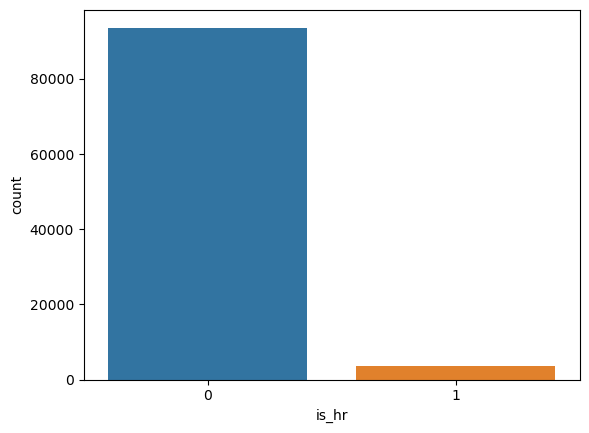

In [13]:
sns.countplot(x='is_hr', data=train_df)

## Exploratory Data Analysis

In [14]:
target = ['is_hr']
categorical_columns = train_df.select_dtypes(include=[object, bool]).columns.to_list()
numeric_columns = train_df.select_dtypes(include=[int, float]).columns.to_list()
numeric_columns.remove('is_hr')


===============Numerical Features===============


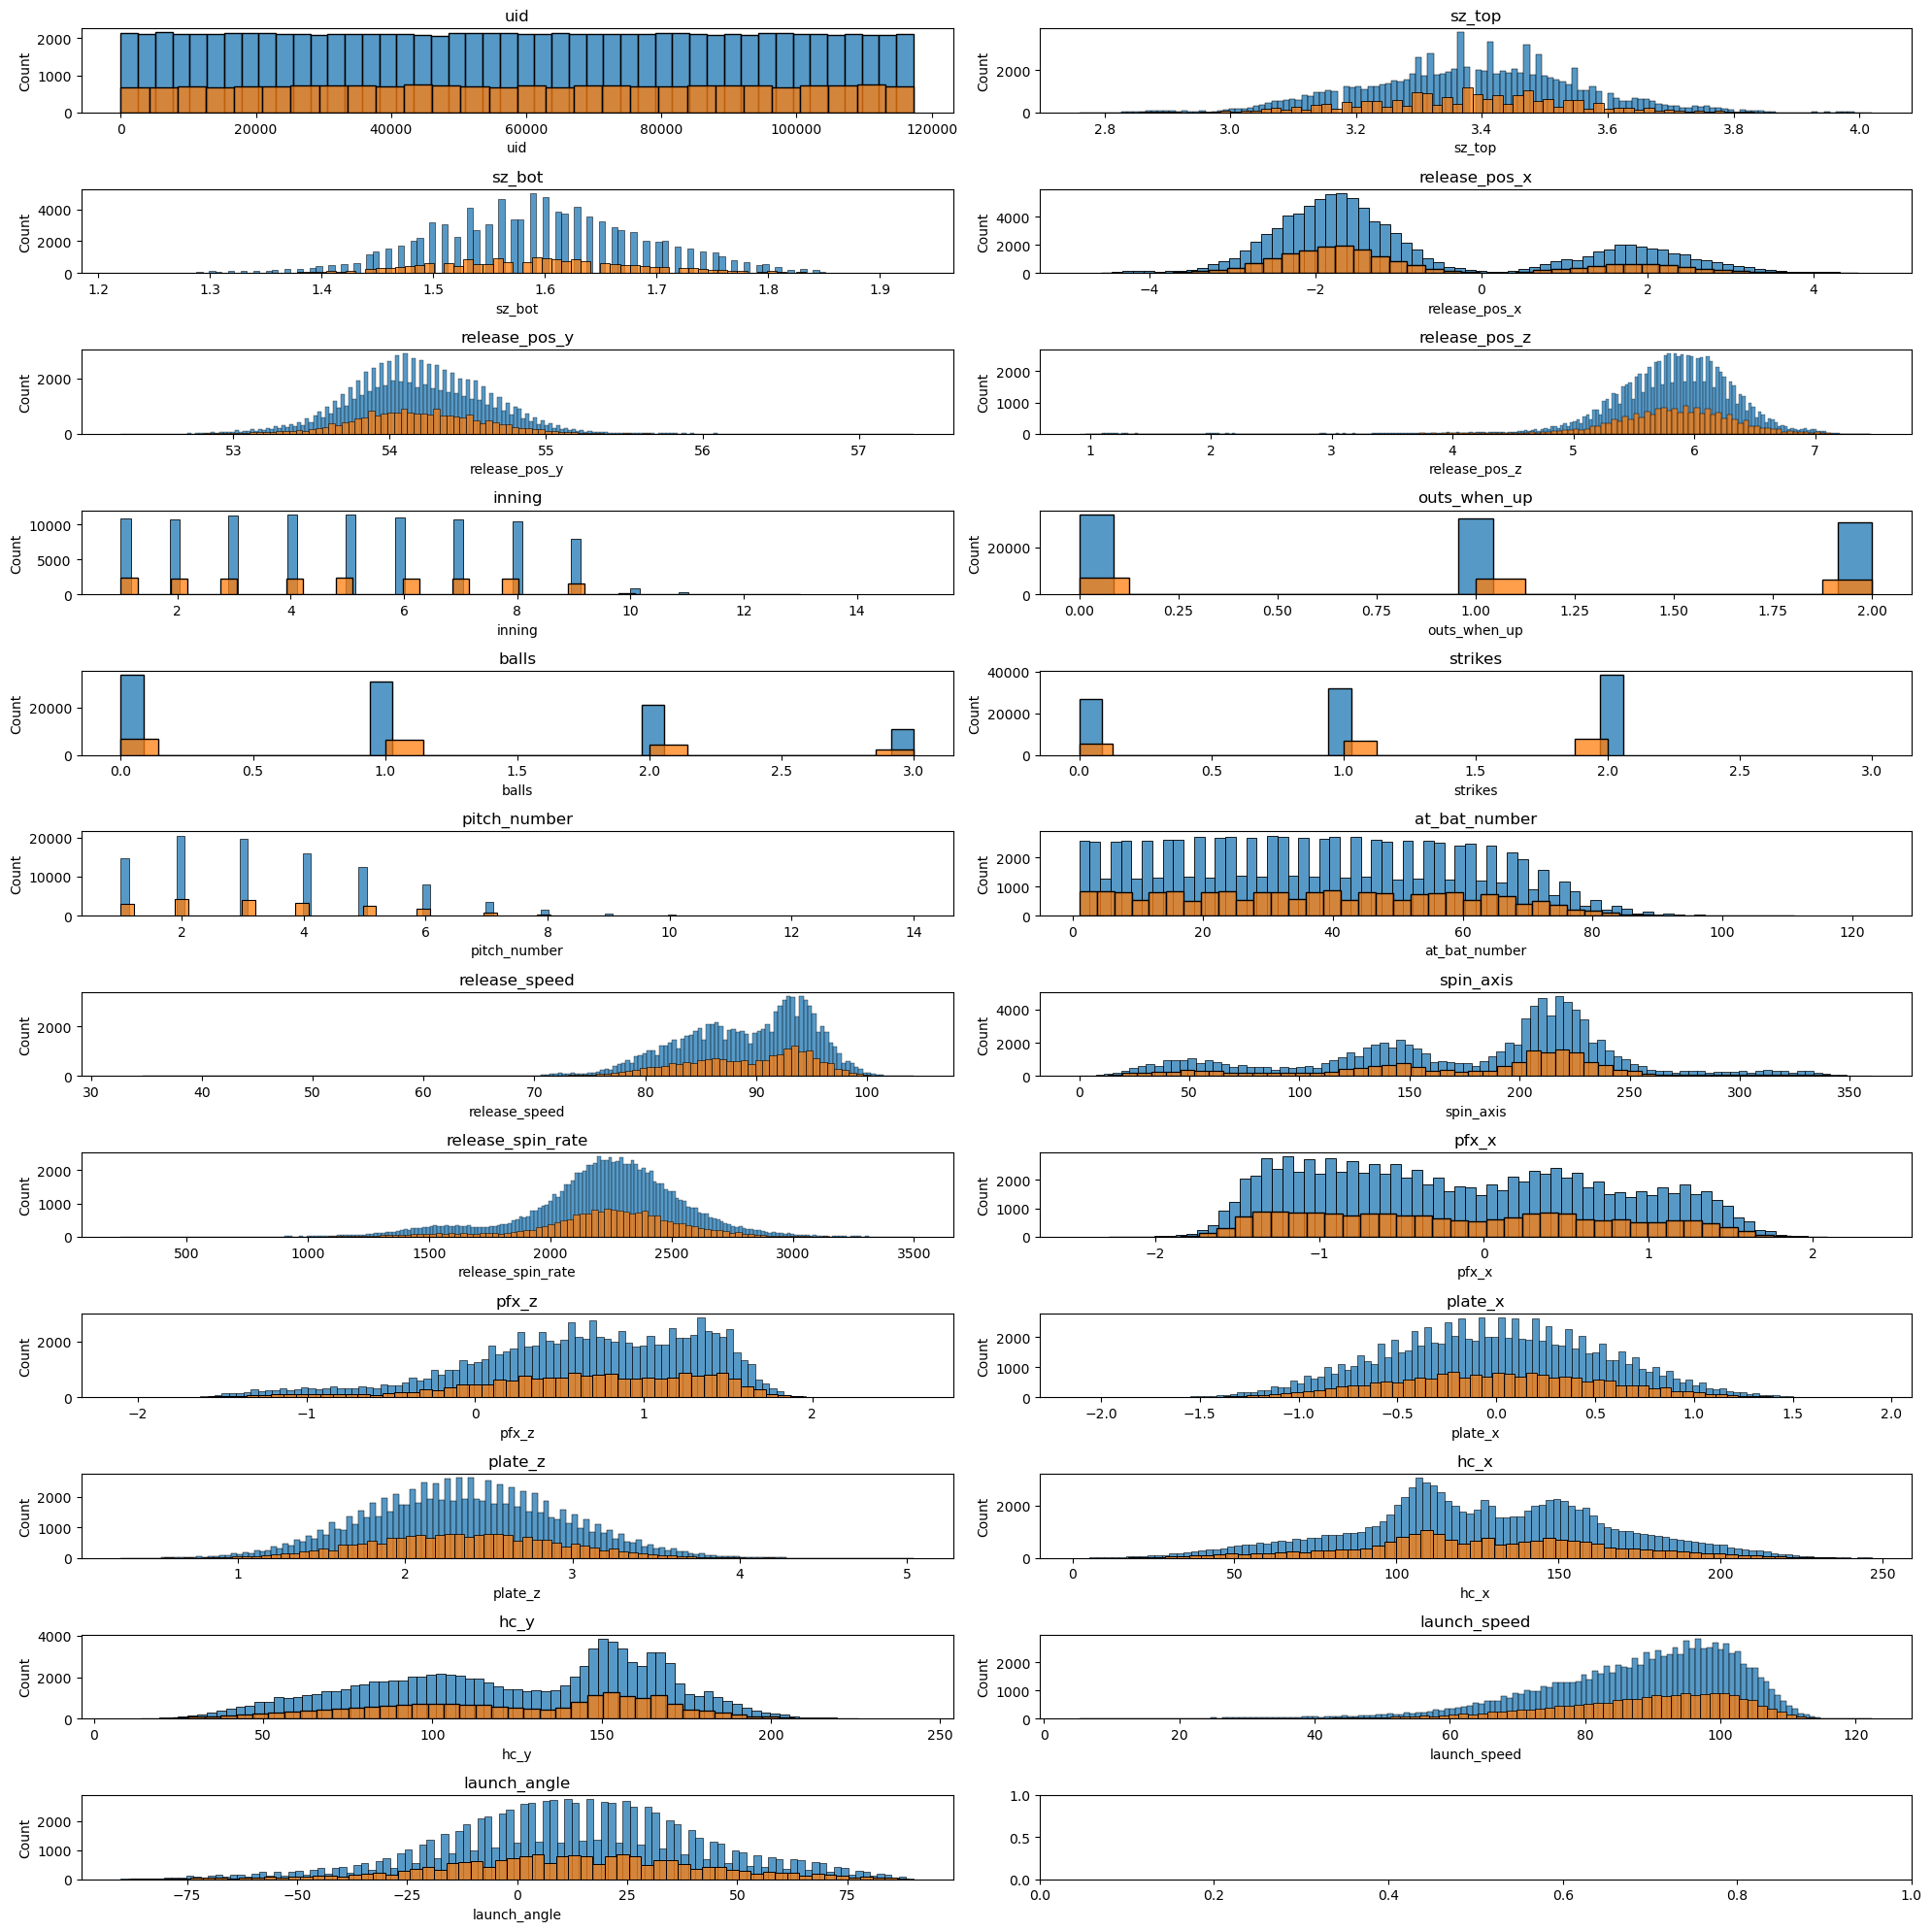

In [15]:
plot_numerical_variable(numeric_columns, train_df, test_df)


===============Categorical Features===============


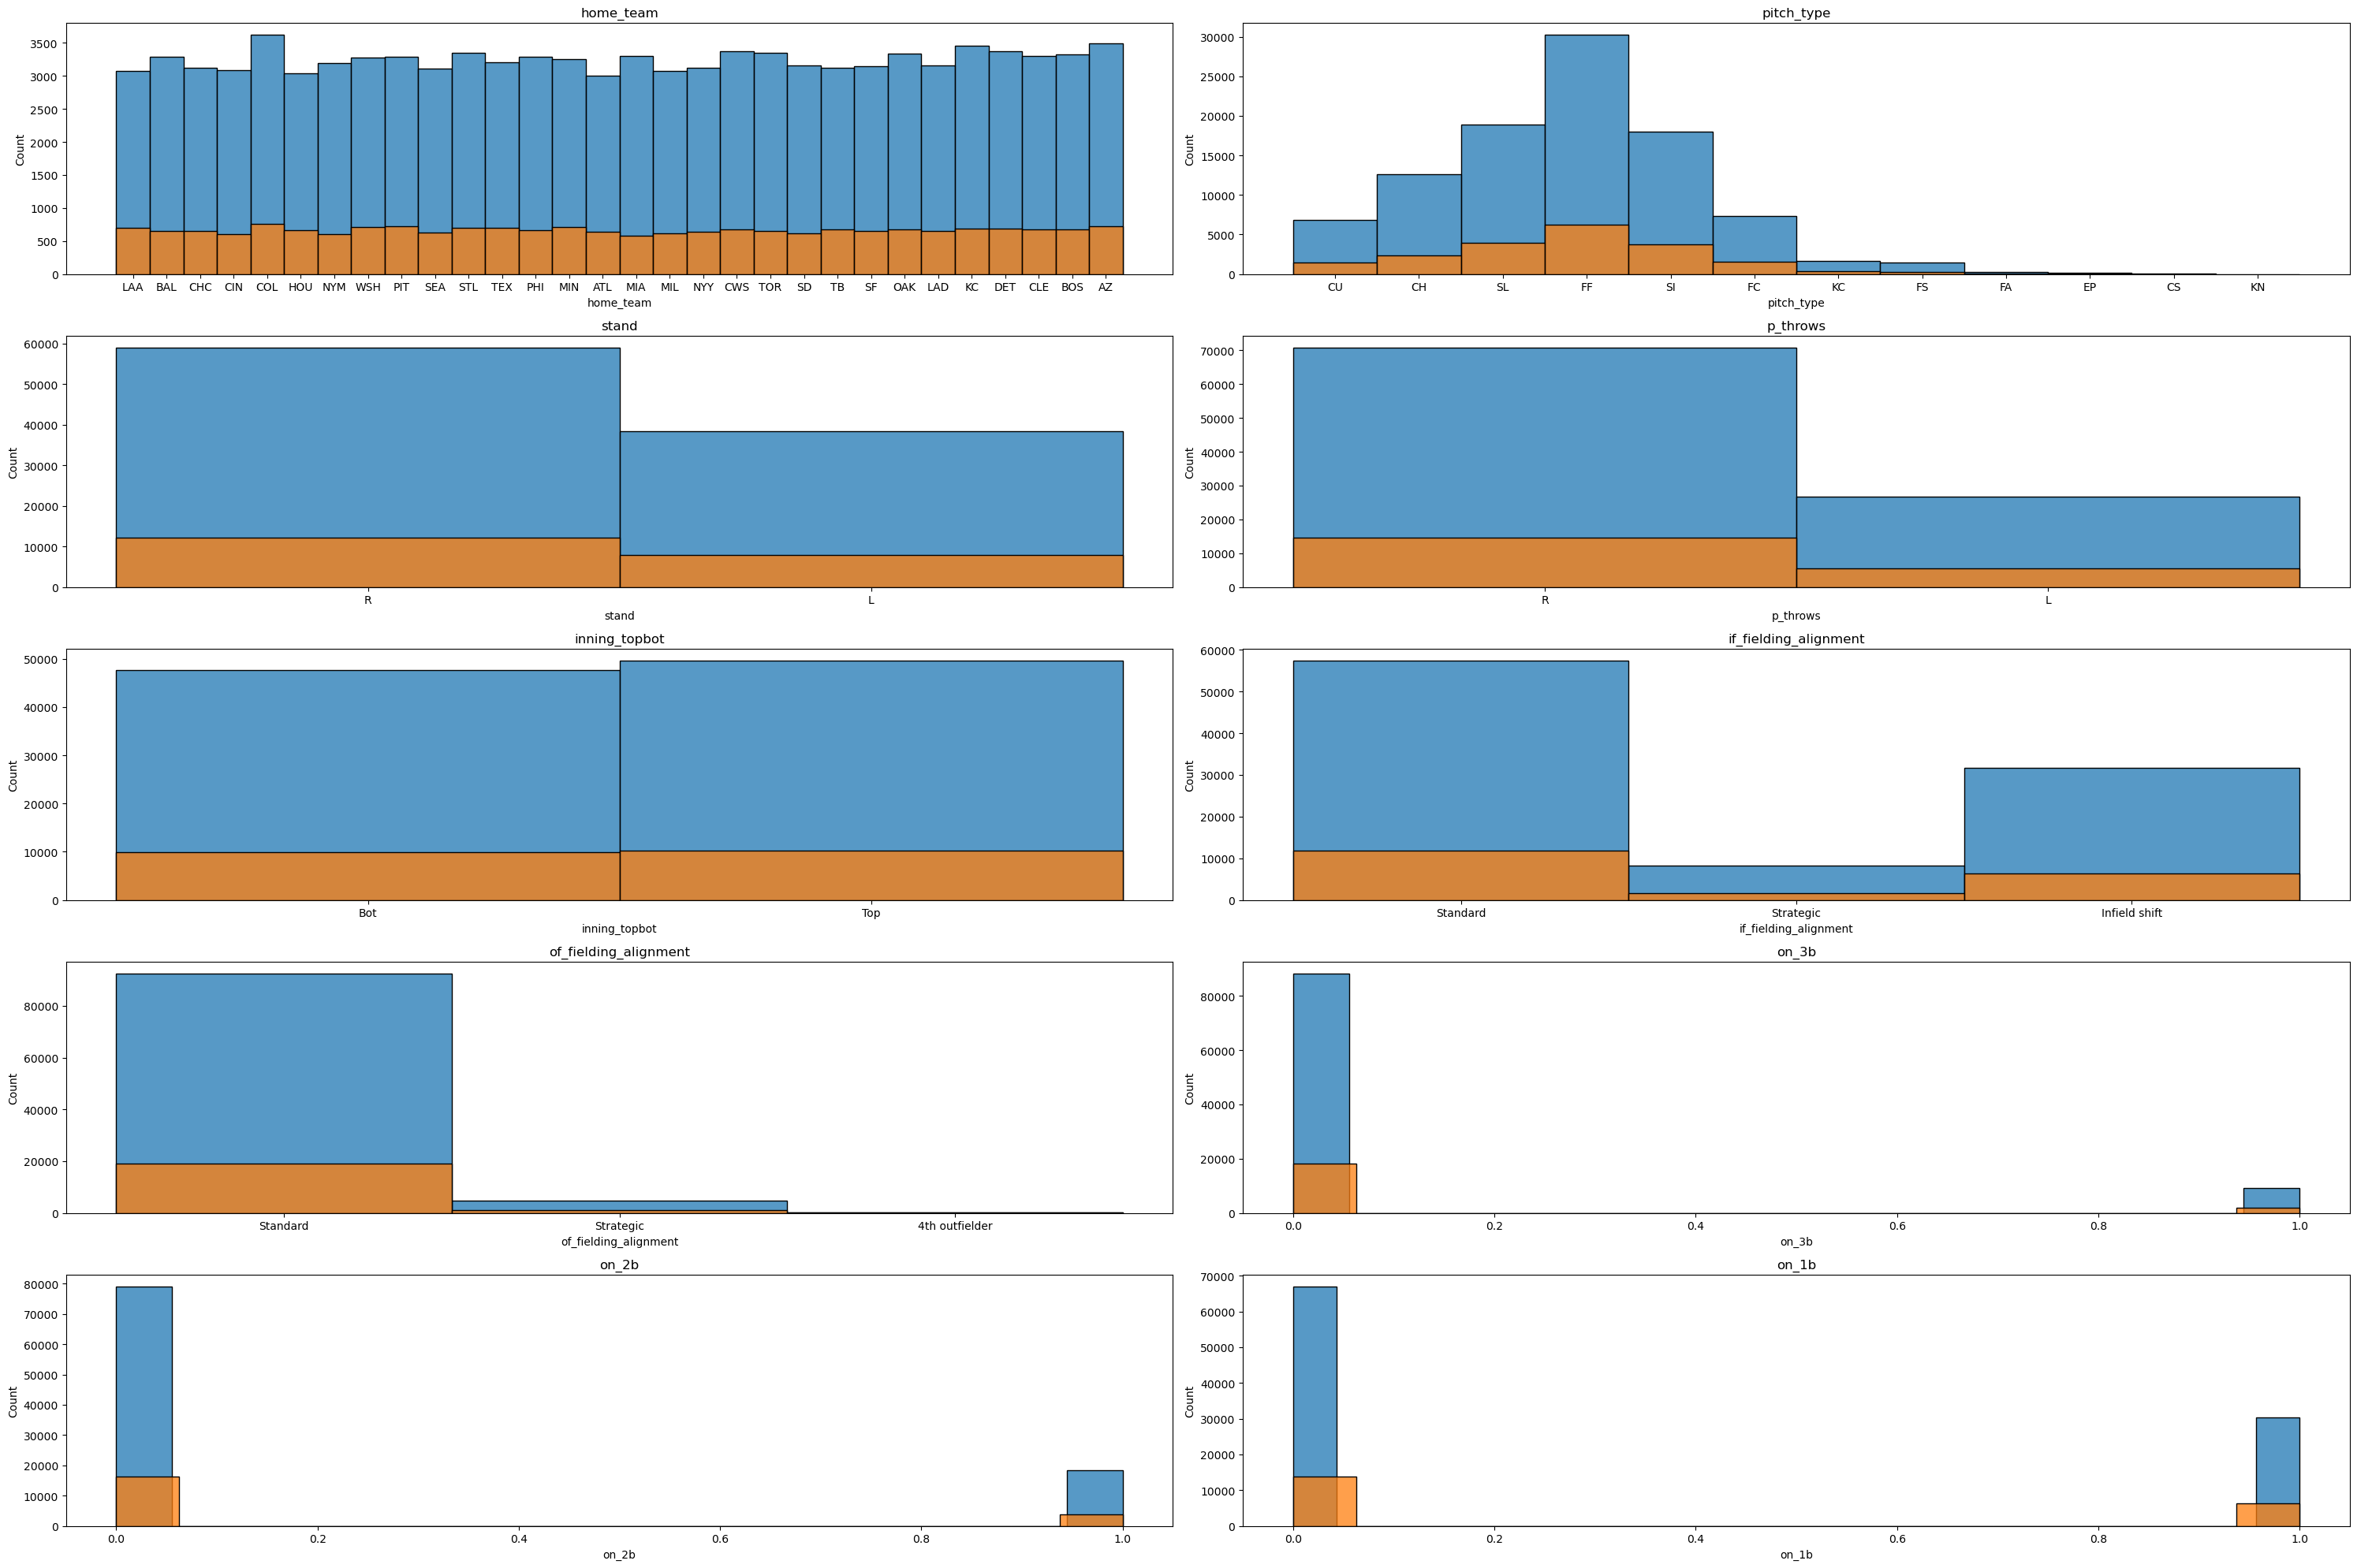

In [16]:
plot_categorical_variable(categorical_columns, train_df, test_df)

## Feature Enginneering

In [17]:
train_df = bases_features(train_df)
train_df = distance_features(train_df)
train_df = transform_features(train_df)

In [18]:
test_df = bases_features(test_df)
test_df = distance_features(test_df)
test_df = transform_features(test_df)

In [19]:
train_df = convert_tocategory(train_df)
test_df = convert_tocategory(test_df)

## Modelling

In [20]:
X = train_df.drop(columns=['is_hr'], axis=1)
y = train_df['is_hr']

## LGBM

In [21]:
best_params = {}
def objective(trial, X, y):
    param_grid = {
        "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 0.95, step=0.1),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95, step=0.1),
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = LGBMClassifier(objective="binary", **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_logloss",
            early_stopping_rounds=100,
            callbacks=[LightGBMPruningCallback(trial, "binary_logloss")],
        )
        
        preds = model.predict_proba(X_test)[:, 1]
        cv_scores[idx] = log_loss(y_test, preds)

    mean_cv_score = np.mean(cv_scores)
    
    # Update the best parameters
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    else:
        best_params.update(model.get_params())
    
    return mean_cv_score

In [22]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=5)

# Retrieve the best parameters
best_params_lgbm = study.best_params

[I 2023-07-18 10:53:53,541] A new study created in memory with name: LGBM Classifier


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_gain_to_split is set=2.032702099162571, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.032702099162571
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0

[I 2023-07-18 10:54:30,958] Trial 0 finished with value: 0.026872005243497192 and parameters: {'device_type': 'gpu', 'n_estimators': 10000, 'learning_rate': 0.2897774976780757, 'num_leaves': 2040, 'max_depth': 11, 'min_data_in_leaf': 1700, 'lambda_l1': 10, 'lambda_l2': 20, 'min_gain_to_split': 2.032702099162571, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 0 with value: 0.026872005243497192.


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_gain_to_split is set=6.32260088839126, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.32260088839126
[LightGBM] [Warning] min_data_in_leaf is set=7400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7400
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0

[I 2023-07-18 10:54:52,284] Trial 1 finished with value: 0.032439290692834875 and parameters: {'device_type': 'gpu', 'n_estimators': 10000, 'learning_rate': 0.21897256503200319, 'num_leaves': 1020, 'max_depth': 8, 'min_data_in_leaf': 7400, 'lambda_l1': 20, 'lambda_l2': 45, 'min_gain_to_split': 6.32260088839126, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 0 with value: 0.026872005243497192.


[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_gain_to_split is set=5.900476990696652, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.900476990696652
[LightGBM] [Warning] min_data_in_leaf is set=6500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6500
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] 

[I 2023-07-18 10:57:43,835] Trial 2 finished with value: 0.03441742099383273 and parameters: {'device_type': 'gpu', 'n_estimators': 10000, 'learning_rate': 0.06570350565664818, 'num_leaves': 320, 'max_depth': 9, 'min_data_in_leaf': 6500, 'lambda_l1': 15, 'lambda_l2': 20, 'min_gain_to_split': 5.900476990696652, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 0 with value: 0.026872005243497192.


[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] min_gain_to_split is set=13.062955358095659, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.062955358095659
[LightGBM] [Warning] min_data_in_leaf is set=5100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5100
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha

[I 2023-07-18 10:58:10,126] Trial 3 finished with value: 0.04827797023379109 and parameters: {'device_type': 'gpu', 'n_estimators': 10000, 'learning_rate': 0.2899127525371896, 'num_leaves': 2620, 'max_depth': 8, 'min_data_in_leaf': 5100, 'lambda_l1': 50, 'lambda_l2': 90, 'min_gain_to_split': 13.062955358095659, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 0 with value: 0.026872005243497192.


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] min_gain_to_split is set=6.873156167760925, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.873156167760925
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] la

[I 2023-07-18 10:58:22,855] Trial 4 finished with value: 0.036933462296004714 and parameters: {'device_type': 'gpu', 'n_estimators': 10000, 'learning_rate': 0.26471684948514357, 'num_leaves': 800, 'max_depth': 5, 'min_data_in_leaf': 1200, 'lambda_l1': 50, 'lambda_l2': 0, 'min_gain_to_split': 6.873156167760925, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 0 with value: 0.026872005243497192.


In [23]:
# # Train the final model with the best parameters on the full dataset
# final_model = LGBMClassifier(objective="binary", **best_params)
# final_model.fit(X, y)

# # Make predictions on the test set
# test_preds = final_model.predict_proba(test_df)[:,1]

### CatBoost

In [24]:
# Define the objective function for CatBoost
def catboost_objective(trial, X, y):
    param_grid = {
        "iterations": trial.suggest_categorical("iterations", [100, 500, 1000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "depth": trial.suggest_int("depth", 3, 12),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0, 10),
        "border_count": trial.suggest_int("border_count", 5, 255),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 10),
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        categorical_cols = X_train.select_dtypes(include=['category']).columns.to_list()

        model = CatBoostClassifier(**param_grid, silent=True, cat_features=categorical_cols)
        model.fit(X_train, 
                  y_train, 
                  eval_set=[(X_test, y_test)], 
                  early_stopping_rounds=100
                 )

        preds = model.predict_proba(X_test)[:, 1]
        cv_scores[idx] = log_loss(y_test, preds)

    mean_cv_score = np.mean(cv_scores)
    return mean_cv_score

In [25]:
study_catboost = optuna.create_study(direction="minimize", study_name="CatBoost Classifier")
func_catboost = lambda trial: catboost_objective(trial, X, y)
study_catboost.optimize(func_catboost, n_trials=5)

# Retrieve the best parameters for CatBoost
best_params_catboost = study_catboost.best_params

[I 2023-07-18 10:58:22,895] A new study created in memory with name: CatBoost Classifier
[I 2023-07-18 11:05:06,779] Trial 0 finished with value: 0.02231019786998078 and parameters: {'iterations': 500, 'learning_rate': 0.10179665585708579, 'depth': 7, 'l2_leaf_reg': 7.085323929461459, 'border_count': 156, 'bagging_temperature': 2.595235321686423}. Best is trial 0 with value: 0.02231019786998078.
[I 2023-07-18 11:11:03,075] Trial 1 finished with value: 0.023831026811160207 and parameters: {'iterations': 1000, 'learning_rate': 0.187343063707646, 'depth': 10, 'l2_leaf_reg': 2.070409368549553, 'border_count': 179, 'bagging_temperature': 6.364076895721736}. Best is trial 0 with value: 0.02231019786998078.
[I 2023-07-18 11:16:51,036] Trial 2 finished with value: 0.02301088934662604 and parameters: {'iterations': 500, 'learning_rate': 0.16949988801360633, 'depth': 8, 'l2_leaf_reg': 8.923363899504695, 'border_count': 158, 'bagging_temperature': 9.850273388653159}. Best is trial 0 with value: 0

## Ensemble Model

In [29]:
categorical_cols = X.select_dtypes(include=['category']).columns.to_list()

In [32]:
# Define the ensemble model using VotingClassifier
ensemble_model = VotingClassifier(
    estimators=[
        ("lgbm", LGBMClassifier(**best_params_lgbm)),
        ("catboost", CatBoostClassifier(**best_params_catboost, silent=True, cat_features = categorical_cols)),
    ],
    voting="soft"
)

In [33]:
# Fit the ensemble model on the full dataset
ensemble_model.fit(X, y)

# Make predictions on the test set
test_preds = ensemble_model.predict_proba(test_df)[:, 1]

In [34]:
test_preds

array([8.84519079e-07, 1.46209860e-06, 9.50469349e-07, ...,
       3.66367467e-07, 7.66770824e-03, 4.30312375e-06])

## Sample Submission

In [35]:
submission = pd.DataFrame(index=test_df['uid'], data=test_preds, columns=['is_hr'])
submission.to_csv('submission.csv')